In [1]:
#Goal - Develop analysis based on dynamic time ranges and parameter selection for sample power usage data
#Perform EDA State a problem to be solved.
#Create a predictive model on the dataset that solves that problem.
#Interpret the results.
#Given the above, present your findings in a concise format to business stakeholders (you can use a short summary document or a few presentation slides)
#Only present data about active (real) power
import pandas as pd

importdf = pd.read_csv('archive\Steel_industry_data.csv')

In [2]:
#Data Discovery to understand various variables in dataset
#Manually inspect data
importdf.head(10)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load
5,01/01/2018 01:30,3.28,3.56,0.0,0.0,67.76,100.0,5400,Weekday,Monday,Light_Load
6,01/01/2018 01:45,3.60,4.14,0.0,0.0,65.62,100.0,6300,Weekday,Monday,Light_Load
7,01/01/2018 02:00,3.60,4.28,0.0,0.0,64.37,100.0,7200,Weekday,Monday,Light_Load
8,01/01/2018 02:15,3.28,3.64,0.0,0.0,66.94,100.0,8100,Weekday,Monday,Light_Load
9,01/01/2018 02:30,3.78,4.72,0.0,0.0,62.51,100.0,9000,Weekday,Monday,Light_Load


In [3]:
# active (real) power relates to Usage_kWh column and time spent from date.

# calculate Power using Usage / .25 (assuming all measurements correspond to .25 hourly increments, will confirm)

# importdf['Power_kW'] = importdf['Usage_kWh'] / .25 - ignoring and using Usage directly
# trim df to relevant columns
relevant_columns = ['date','Usage_kWh','NSM','WeekStatus','Day_of_week','Load_Type']
trimmed_df = importdf[relevant_columns]

# utilize canned EDA script to visually inspect data
def explore_data(df):
    exploratory_results = {}

    for col in trimmed_df.columns:
        min_val = importdf[col].min()
        max_val = importdf[col].max()
        null_count = importdf[col].isnull().sum()
        zero_count = (importdf[col] == 0).sum()
        dtype = importdf[col].dtype
        most_common_values = importdf[col].value_counts().head(5).to_dict()
        exploratory_results[col] = {
            'min': min_val,
            'max': max_val,
            'null_count': null_count,
            'zero_count': zero_count,
            'dtype': dtype,
            'most_common_values': most_common_values
        }

    exploratory_df = pd.DataFrame.from_dict(exploratory_results, orient='index')

    return exploratory_df

exploratory_df = explore_data(trimmed_df)
print(exploratory_df)

                          min               max  null_count  zero_count  \
date         01/01/2018 00:00  31/12/2018 23:45           0           0   
Usage_kWh                 0.0            157.18           0           1   
NSM                         0             85500           0         365   
WeekStatus            Weekday           Weekend           0           0   
Day_of_week            Friday         Wednesday           0           0   
Load_Type          Light_Load       Medium_Load           0           0   

               dtype                                 most_common_values  
date          object  {'01/01/2018 00:15': 1, '01/09/2018 08:45': 1,...  
Usage_kWh    float64  {3.06: 631, 2.95: 609, 2.92: 598, 3.02: 560, 2...  
NSM            int64  {900: 365, 1800: 365, 63900: 365, 63000: 365, ...  
WeekStatus    object                {'Weekday': 25056, 'Weekend': 9984}  
Day_of_week   object  {'Monday': 5088, 'Tuesday': 4992, 'Wednesday':...  
Load_Type     object  {'Light_

In [5]:
# determined needed to convert date based on errors while plotting
trimmed_df['date'] = pd.to_datetime(trimmed_df['date'],format="%d/%m/%Y %H:%M")

trimmed_df['day'] = trimmed_df['date'].dt.date

records_per_day = trimmed_df.groupby('day').size().reset_index(name='record_count')
records_per_day = records_per_day.sort_values(by='record_count', ascending=True)

# confirm all days have 96 records, corresponding to 15 minute intervals
print(records_per_day)

            day  record_count
0    2018-01-01            96
247  2018-09-05            96
246  2018-09-04            96
245  2018-09-03            96
244  2018-09-02            96
..          ...           ...
117  2018-04-28            96
116  2018-04-27            96
115  2018-04-26            96
113  2018-04-24            96
364  2018-12-31            96

[365 rows x 2 columns]


<ipython-input-5-f0a510bb8e89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df['date'] = pd.to_datetime(trimmed_df['date'],format="%d/%m/%Y %H:%M")
<ipython-input-5-f0a510bb8e89>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df['day'] = trimmed_df['date'].dt.date


In [6]:

trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         35040 non-null  datetime64[ns]
 1   Usage_kWh    35040 non-null  float64       
 2   NSM          35040 non-null  int64         
 3   WeekStatus   35040 non-null  object        
 4   Day_of_week  35040 non-null  object        
 5   Load_Type    35040 non-null  object        
 6   day          35040 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.9+ MB


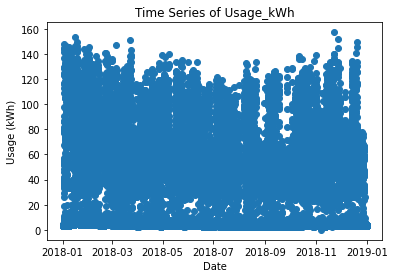

In [7]:
plt.plot(trimmed_df['date'].values, trimmed_df['Usage_kWh'].values, marker='o', linestyle='')
plt.title('Time Series of Usage_kWh')
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.grid(False)
plt.show()

<ipython-input-8-9eae27f20299>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df['day'] = trimmed_df['date'].dt.date
<ipython-input-8-9eae27f20299>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_df['hour_of_day'] = trimmed_df['date'].dt.hour


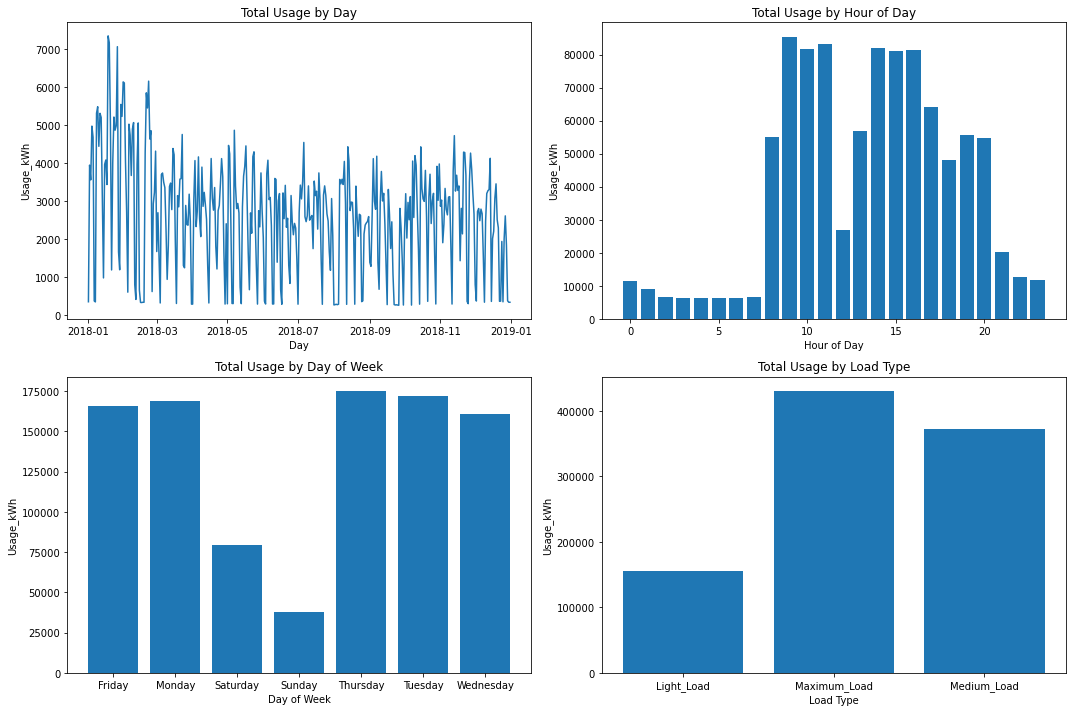

In [8]:
# Prep data to view: Total Daily Use, Total Use by Hour of Day, Total Use by Day of Week, and Total Use by Load Type
# Understand high level usage trends related to production

trimmed_df['day'] = trimmed_df['date'].dt.date
trimmed_df['hour_of_day'] = trimmed_df['date'].dt.hour

total_usage_by_day = trimmed_df.groupby('day')['Usage_kWh'].sum()

total_usage_by_hour = trimmed_df.groupby('hour_of_day')['Usage_kWh'].sum()

total_usage_by_day_of_week = trimmed_df.groupby('Day_of_week')['Usage_kWh'].sum()

total_usage_by_load_type = trimmed_df.groupby('Load_Type')['Usage_kWh'].sum()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(total_usage_by_day.index.values, total_usage_by_day.values)
axs[0, 0].set_title('Total Usage by Day')
axs[0, 0].set_xlabel('Day')
axs[0, 0].set_ylabel('Usage_kWh')

axs[0, 1].bar(total_usage_by_hour.index.values, total_usage_by_hour.values)
axs[0, 1].set_title('Total Usage by Hour of Day')
axs[0, 1].set_xlabel('Hour of Day')
axs[0, 1].set_ylabel('Usage_kWh')

axs[1, 0].bar(total_usage_by_day_of_week.index.values, total_usage_by_day_of_week.values)
axs[1, 0].set_title('Total Usage by Day of Week')
axs[1, 0].set_xlabel('Day of Week')
axs[1, 0].set_ylabel('Usage_kWh')

axs[1, 1].bar(total_usage_by_load_type.index.values, total_usage_by_load_type.values)
axs[1, 1].set_title('Total Usage by Load Type')
axs[1, 1].set_xlabel('Load Type')
axs[1, 1].set_ylabel('Usage_kWh')

plt.tight_layout()
plt.show()


In [9]:
# Develop new columns to prepare for report creation
# Add Prior Week Usage to allow for WoW comparisons


trimmed_df = trimmed_df.sort_values(by='date')

# Create a new column 'Prior Week Usage'
trimmed_df['Prior_Week_Minus_One_Usage_kWh'] = trimmed_df['date'].map(lambda x: x - pd.Timedelta(days=7)).map(trimmed_df.set_index('date')['Usage_kWh'])

trimmed_df.head(5000)

,date,Usage_kWh,NSM,WeekStatus,Day_of_week,Load_Type,day,hour_of_day,Prior_Week_Minus_One_Usage_kWh
95,2018-01-01 00:00:00,3.42,0,Weekday,Monday,Light_Load,2018-01-01,0,NaN
0,2018-01-01 00:15:00,3.17,900,Weekday,Monday,Light_Load,2018-01-01,0,NaN
1,2018-01-01 00:30:00,4.00,1800,Weekday,Monday,Light_Load,2018-01-01,0,NaN
2,2018-01-01 00:45:00,3.24,2700,Weekday,Monday,Light_Load,2018-01-01,0,NaN
3,2018-01-01 01:00:00,3.31,3600,Weekday,Monday,Light_Load,2018-01-01,1,NaN
...,...,...,...,...,...,...,...,...,...
4994,2018-02-22 00:45:00,66.92,2700,Weekday,Thursday,Light_Load,2018-02-22,0,3.89
4995,2018-02-22 01:00:00,90.18,3600,Weekday,Thursday,Light_Load,2018-02-22,1,3.46
4996,2018-02-22 01:15:00,74.81,4500,Weekday,Thursday,Light_Load,2018-02-22,1,3.96
4997,2018-02-22 01:30:00,13.54,5400,Weekday,Thursday,Light_Load,2018-02-22,1,3.35


In [10]:
# Confirmation that datemath worked correctly
trimmed_df[(trimmed_df['date'] =='2018-02-22 00:15:00') | (trimmed_df['date'] =='2018-02-15 00:15:00')]

,date,Usage_kWh,NSM,WeekStatus,Day_of_week,Load_Type,day,hour_of_day,Prior_Week_Minus_One_Usage_kWh
4320,2018-02-15 00:15:00,3.17,900,Weekday,Thursday,Light_Load,2018-02-15,0,30.67
4992,2018-02-22 00:15:00,75.85,900,Weekday,Thursday,Light_Load,2018-02-22,0,3.17


In [11]:
# Add more columns to generate last six weeks worth of data

trimmed_df['Prior_Week_Minus_Two_Usage_kWh'] = trimmed_df['date'].map(lambda x: x - pd.Timedelta(days=14)).map(trimmed_df.set_index('date')['Usage_kWh'])

trimmed_df['Prior_Week_Minus_Three_Usage_kWh'] = trimmed_df['date'].map(lambda x: x - pd.Timedelta(days=21)).map(trimmed_df.set_index('date')['Usage_kWh'])

trimmed_df['Prior_Week_Minus_Four_Usage_kWh'] = trimmed_df['date'].map(lambda x: x - pd.Timedelta(days=28)).map(trimmed_df.set_index('date')['Usage_kWh'])

trimmed_df['Prior_Week_Minus_Five_Usage_kWh'] = trimmed_df['date'].map(lambda x: x - pd.Timedelta(days=35)).map(trimmed_df.set_index('date')['Usage_kWh'])

trimmed_df['Prior_Week_Minus_Six_Usage_kWh'] = trimmed_df['date'].map(lambda x: x - pd.Timedelta(days=42)).map(trimmed_df.set_index('date')['Usage_kWh'])

trimmed_df.sort_values(by='date', ascending = False).head(10)

,date,Usage_kWh,NSM,WeekStatus,Day_of_week,Load_Type,day,hour_of_day,Prior_Week_Minus_One_Usage_kWh,Prior_Week_Minus_Two_Usage_kWh,Prior_Week_Minus_Three_Usage_kWh,Prior_Week_Minus_Four_Usage_kWh,Prior_Week_Minus_Five_Usage_kWh,Prior_Week_Minus_Six_Usage_kWh
35038,2018-12-31 23:45:00,3.78,85500,Weekday,Monday,Light_Load,2018-12-31,23,3.85,4.07,4.28,4.61,4.64,4.57
35037,2018-12-31 23:30:00,3.78,84600,Weekday,Monday,Light_Load,2018-12-31,23,3.82,4.07,4.21,4.57,4.64,3.64
35036,2018-12-31 23:15:00,3.74,83700,Weekday,Monday,Light_Load,2018-12-31,23,3.85,4.14,4.18,4.61,4.82,3.56
35035,2018-12-31 23:00:00,3.85,82800,Weekday,Monday,Light_Load,2018-12-31,23,3.85,4.18,4.18,4.68,4.72,3.56
35034,2018-12-31 22:45:00,3.82,81900,Weekday,Monday,Light_Load,2018-12-31,22,3.89,4.21,4.32,4.68,4.75,3.60
35033,2018-12-31 22:30:00,3.67,81000,Weekday,Monday,Light_Load,2018-12-31,22,3.92,4.18,4.25,4.75,4.72,3.64
35032,2018-12-31 22:15:00,3.24,80100,Weekday,Monday,Light_Load,2018-12-31,22,4.50,4.14,4.28,4.72,4.79,3.67
35031,2018-12-31 22:00:00,3.42,79200,Weekday,Monday,Light_Load,2018-12-31,22,5.40,4.46,4.46,4.93,5.11,3.78
35030,2018-12-31 21:45:00,3.42,78300,Weekday,Monday,Light_Load,2018-12-31,21,4.18,4.46,4.54,5.62,5.26,3.89
35029,2018-12-31 21:30:00,3.49,77400,Weekday,Monday,Light_Load,2018-12-31,21,4.14,4.43,4.57,6.19,6.23,3.82


In [14]:
usage_columns = [
    'Prior_Week_Minus_One_Usage_kWh', 'Prior_Week_Minus_Two_Usage_kWh',
    'Prior_Week_Minus_Three_Usage_kWh', 'Prior_Week_Minus_Four_Usage_kWh',
    'Prior_Week_Minus_Five_Usage_kWh', 'Prior_Week_Minus_Six_Usage_kWh'
]

trimmed_df['min_usage_past_six_weeks'] = trimmed_df[usage_columns].min(axis=1)
trimmed_df['max_usage_past_six_weeks'] = trimmed_df[usage_columns].max(axis=1)
trimmed_df['median_usage_past_six_weeks'] = trimmed_df[usage_columns].median(axis=1)
trimmed_df.sort_values(by='date', ascending = False).head(10)

,date,Usage_kWh,NSM,WeekStatus,Day_of_week,Load_Type,day,hour_of_day,Prior_Week_Minus_One_Usage_kWh,Prior_Week_Minus_Two_Usage_kWh,Prior_Week_Minus_Three_Usage_kWh,Prior_Week_Minus_Four_Usage_kWh,Prior_Week_Minus_Five_Usage_kWh,Prior_Week_Minus_Six_Usage_kWh,min_usage_past_six_weeks,max_usage_past_six_weeks,median_usage_past_six_weeks
35038,2018-12-31 23:45:00,3.78,85500,Weekday,Monday,Light_Load,2018-12-31,23,3.85,4.07,4.28,4.61,4.64,4.57,3.85,4.64,4.425
35037,2018-12-31 23:30:00,3.78,84600,Weekday,Monday,Light_Load,2018-12-31,23,3.82,4.07,4.21,4.57,4.64,3.64,3.64,4.64,4.140
35036,2018-12-31 23:15:00,3.74,83700,Weekday,Monday,Light_Load,2018-12-31,23,3.85,4.14,4.18,4.61,4.82,3.56,3.56,4.82,4.160
35035,2018-12-31 23:00:00,3.85,82800,Weekday,Monday,Light_Load,2018-12-31,23,3.85,4.18,4.18,4.68,4.72,3.56,3.56,4.72,4.180
35034,2018-12-31 22:45:00,3.82,81900,Weekday,Monday,Light_Load,2018-12-31,22,3.89,4.21,4.32,4.68,4.75,3.60,3.60,4.75,4.265
35033,2018-12-31 22:30:00,3.67,81000,Weekday,Monday,Light_Load,2018-12-31,22,3.92,4.18,4.25,4.75,4.72,3.64,3.64,4.75,4.215
35032,2018-12-31 22:15:00,3.24,80100,Weekday,Monday,Light_Load,2018-12-31,22,4.50,4.14,4.28,4.72,4.79,3.67,3.67,4.79,4.390
35031,2018-12-31 22:00:00,3.42,79200,Weekday,Monday,Light_Load,2018-12-31,22,5.40,4.46,4.46,4.93,5.11,3.78,3.78,5.40,4.695
35030,2018-12-31 21:45:00,3.42,78300,Weekday,Monday,Light_Load,2018-12-31,21,4.18,4.46,4.54,5.62,5.26,3.89,3.89,5.62,4.500
35029,2018-12-31 21:30:00,3.49,77400,Weekday,Monday,Light_Load,2018-12-31,21,4.14,4.43,4.57,6.19,6.23,3.82,3.82,6.23,4.500


In [16]:
filename = "dashboard_MVP.csv"

trimmed_df.to_csv(filename, index=False)
#Use this file in Tableau